화일의 데이터 행수 ==> 650
🛑 개발 중단된 프로젝트 수: 4
✅ Excel 통합 파일 저장 완료: Outputs\2025-07-07_10-13\통합_출력파일_2025-07-07_10-13.xlsx
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output.jpg


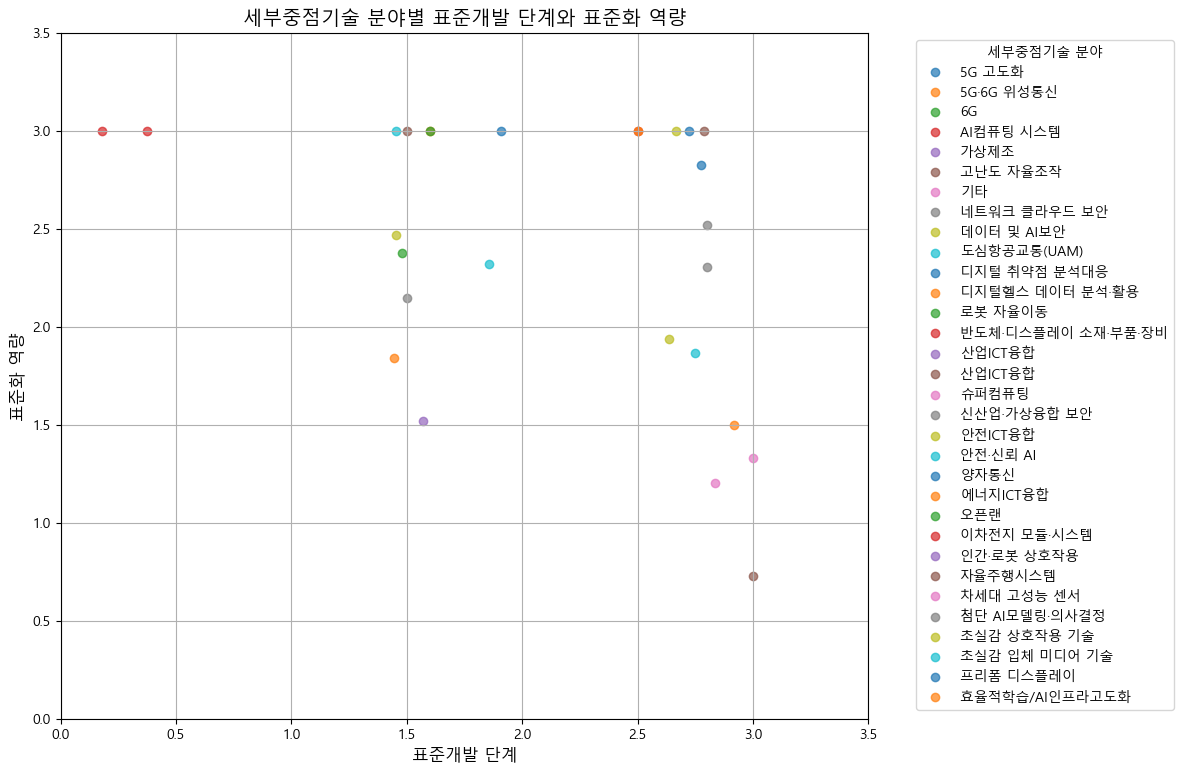

✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_1) 반도체·디스플레이.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_10) 메타버스.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_11) 초성능컴퓨팅.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_12) ICT융합.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_2) 이차전지.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_3) 첨단모빌리티.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_4) 첨단바이오.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_5) 사이버보안.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_6) 인공지능.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_7) 차세대통신.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_8) 첨단로봇제조.jpg
✅ 그림 저장 완료: Outputs\2025-07-07_10-13\graph_output_9) 양자.jpg
모든 전략기술 분야별 그림이 개별 파일로 저장되었습니다.


In [1]:
import warnings
import os
from datetime import datetime
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# ───────────────공통 설정 ───────────────
# Outputs 폴더 생성 + 날짜/시간별 하위 폴더 생성
output_root = "Outputs"
now_str = datetime.now().strftime("%Y-%m-%d_%H-%M")
output_dir = os.path.join(output_root, now_str)
os.makedirs(output_dir, exist_ok=True)

def save_figure(plt_obj, filename):
    """plt 객체를 날짜/시간별 폴더에 그림으로 저장하는 함수"""
    full_path = os.path.join(output_dir, f"{filename}.jpg")
    plt_obj.savefig(full_path, dpi=300, bbox_inches='tight')
    print(f"✅ 그림 저장 완료: {full_path}")

# ───────────────의장단 추출 ───────────────
def extract_position_and_name(text):
    if not isinstance(text, str):
        text = str(text)
    entries = re.findall(r'([가-힣A-Za-z0-9\s/.\-]+?\([가-힣]{2,4}\))', text)
    unique_entries = sorted(set(entry.strip() for entry in entries if entry.strip()))
    return unique_entries

def extract_unique_names(series):
    """Series 전체에서 고유한 이름만 추출"""
    names_set = set()
    for text in series:
        extracted = extract_position_and_name(text)
        names_set.update(extracted)
    return sorted(names_set)


def add_chair_summary(df, group_cols):
    temp_df = df.copy()
    temp_df['ETRI 의장단'] = temp_df['ETRI 의장단'].fillna('').astype(str).str.strip()
    temp_df = temp_df[(temp_df['ETRI 의장단'] != '') & (temp_df['ETRI 의장단'] != '0') & (temp_df['ETRI 의장단'] != '-')]
    grouped = temp_df.groupby(group_cols)['ETRI 의장단'].apply(extract_unique_names).reset_index()
    grouped['의장단 명단'] = grouped['ETRI 의장단'].apply(lambda lst: ', '.join(lst))
    grouped['의장단 총수'] = grouped['ETRI 의장단'].apply(len)
    grouped = grouped.drop(columns=['ETRI 의장단'])
    cols = [c for c in grouped.columns if c not in ('의장단 총수', '의장단 명단')] + ['의장단 총수', '의장단 명단']
    return grouped[cols]
    
# ───────────────한글폰트 설정 ───────────────
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")


# ───────────────전처리 ───────────────
def create_dataframe_from_excel(file_path, sheet_index=0):
    xls = pd.ExcelFile(file_path)
    return pd.read_excel(xls, sheet_name=xls.sheet_names[sheet_index], header=0)

def get_excel_file_paths(data_dir):
    return [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith('.xlsx')]

def remove_front_end_space(df):
    df['표준기구'] = df['표준기구'].str.strip()
    return df

def filter_non_null_rows(df):
    mask = df['소'].notna() & df['순번'].isna()
    df.loc[mask, '순번'] = 0
    valid = df['순번'].apply(lambda x: (isinstance(x, str) and x.strip() == '신규') or pd.notna(pd.to_numeric(x, errors='coerce')))
    return df[df['소'].notna() & valid]

def count_names(text):
    if text == 0:
        return 0
    names = re.split(r'[,]+|\n+', text)
    return len([n.strip() for n in names if n.strip()])

def count_progress(text, keyword): 
    return 1 if text == keyword else 0

def compute_development_stage(row):
    total = row['표준건수 합계']
    if total == 0:
        return 0.0
    plan, propose = row['표준계획 건수'], row['표준제안 건수']
    dev, rec = row['표준개발 건수'], row['표준완료 건수']
    if (plan + propose)/total >= dev/total and (plan + propose)/total >= rec/total:
        return (plan*0.5 + propose*0.5)/total
    if dev/total >= rec/total:
        return 1 + dev/total
    return 2 + rec/total

# ──────────────── 메인 ────────────────
def main(data_dir):
    paths = get_excel_file_paths(data_dir)
    df_std = create_dataframe_from_excel(paths[0])
    df_std = remove_front_end_space(df_std)
    df_std = filter_non_null_rows(df_std)
    print(f"화일의 데이터 행수 ==> {len(df_std)}")

    for col in ['ETRI 기고자', 'ETRI 에디터(예정포함)', 'ETRI 의장단']:
        df_std[col] = df_std[col].fillna(0)

    # 파생 컬럼 일괄 생성
    df_std['기고자수'] = df_std['ETRI 기고자'].apply(count_names)
    df_std['에디터수'] = df_std['ETRI 에디터(예정포함)'].apply(count_names)
    df_std['의장단수'] = df_std['ETRI 의장단'].apply(lambda x: len(extract_position_and_name(x)))

    progress_keywords = {
        '표준완료 건수': '제정완료',
        '표준개발 건수': '개발중',
        '표준제안 건수': '제안중',
        '표준계획 건수': '계획중',
        '개발중단 건수': '개발중단'
    }
    for col, keyword in progress_keywords.items():
        df_std[col] = df_std['표준화 상태'].apply(lambda x: count_progress(x, keyword))
        
    # 연도 보정
    for col in ['(예정) 시작년도  ', '(예정) 완료연도']:
        df_std[col] = df_std[col].apply(lambda v: f"'{int(v)%100:02d}" if isinstance(v, (int, float)) and float(v).is_integer() else v)


    # ============================
    # 개발중단된 프로젝트 수 출력
    stopped_count = df_std['개발중단 건수'].sum()
    print(f"🛑 개발 중단된 프로젝트 수: {stopped_count}")

    # ============================
    # 그룹 정의
    
    group_definitions = [
         (['소'], ['표준완료 건수','표준개발 건수','표준제안 건수','표준계획 건수'], "연차별현황"),
         (['전략기술 분야','소'],['표준완료 건수','표준개발 건수','표준제안 건수','표준계획 건수','에디터수','기고자수','표준특허 개수'], "현황총괄"),
         (['전략기술 분야','세부중점기술 분야','소','본부(단)'],
          ['표준완료 건수','표준개발 건수','표준제안 건수','표준계획 건수','에디터수','기고자수','표준특허 개수'], "42대중점세부"),
         (['전략기술 분야','표준기구'],
          ['표준완료 건수','표준개발 건수','표준제안 건수','표준계획 건수','에디터수','기고자수','표준특허 개수'], "주요참여표준기구"),
         (['전략기술 분야','소','본부(단)','표준기구'],
          ['표준완료 건수','표준개발 건수','에디터수','기고자수','표준특허 개수'], "표준화 수행 연구부서"),
         (['전략기술 분야','소','본부(단)','표준기구'], ['표준특허 개수'], "표준특허확보"),
         (['전략기술 분야','사업분류'], ['사업분류'], "관련사업현황"),
         (['전략기술 분야'],
          ['표준완료 건수','표준개발 건수','표준제안 건수','표준계획 건수','에디터수','기고자수','표준특허 개수'], "부록II_12대전략"),
         (['전략기술 분야'], [],"전략_의장단"),
         (['표준기구'], [], "표준기구_의장단"),
     ]
 
    grouped_dfs = []
    for group_cols, agg_cols, name in group_definitions:
        if name == "관련사업현황":
            grouped = (
                df_std.groupby(['전략기술 분야', '사업분류'], as_index=False)
                .size()
                .rename(columns={'size': '사업분류수'})
            )
        else:
            agg_cols_clean = [col for col in agg_cols if col != '의장단수']
            grouped = df_std.groupby(group_cols, as_index=False)[agg_cols_clean].sum()
            
            # ✅ "연차별현황, 42대중점세부" merge skip
            
            if name not in ["연차별현황", "42대중점세부", "표준특허확보"]:
                chairs_summary = add_chair_summary(df_std, group_cols)
                grouped = grouped.merge(chairs_summary, on=group_cols, how='left')
        
        grouped_dfs.append((grouped, name))
    # ============================

    # grouped15 (표준화 단계)
    # 집계할 컬럼에서 의장단수는 제외
    agg_cols = ['표준계획 건수', '표준제안 건수', '표준개발 건수', '표준완료 건수', '에디터수', '기고자수']

  
    grouped15 = df_std.groupby(['전략기술 분야', '세부중점기술 분야'], as_index=False)[agg_cols].sum()

    # 의장단 고유 인원수 merge
    chairs_summary = add_chair_summary(df_std, ['전략기술 분야', '세부중점기술 분야'])
    grouped15 = grouped15.merge(chairs_summary, on=['전략기술 분야', '세부중점기술 분야'], how='left')
    
    # 표준건수 합계 계산
    grouped15['표준건수 합계'] = grouped15[['표준계획 건수', '표준제안 건수', '표준개발 건수', '표준완료 건수']].sum(axis=1)
    
    # 표준개발 단계 계산
    grouped15['표준개발 단계'] = grouped15.apply(compute_development_stage, axis=1)
    
    # 표준화 역량 계산값
    grouped15['표준화 역량 계산값'] = (
        np.log(1 + grouped15['의장단 총수'] * 0.1) +
        np.log(1 + grouped15['에디터수'] * 0.2) +
        np.log(1 + grouped15['기고자수'] * 0.7)
    ) / 100
    
    # 최대값 기준 normalize
    max_by_field = grouped15[~grouped15['세부중점기술 분야'].str.contains('기타')].groupby('전략기술 분야')['표준화 역량 계산값'].transform('max')
    grouped15['표준화 역량'] = (grouped15['표준화 역량 계산값'] / max_by_field) * 3
    
    # 종합활동 점수
    dev_stage_range = grouped15['표준개발 단계'].max() - grouped15['표준개발 단계'].min()
    if dev_stage_range == 0:
        grouped15['norm_dev_stage'] = 0
    else:
        grouped15['norm_dev_stage'] = (grouped15['표준개발 단계'] - grouped15['표준개발 단계'].min()) / dev_stage_range
    
    capability_range = grouped15['표준화 역량 계산값'].max() - grouped15['표준화 역량 계산값'].min()
    if capability_range == 0:
        grouped15['norm_capability'] = 0
    else:
        grouped15['norm_capability'] = (grouped15['표준화 역량 계산값'] - grouped15['표준화 역량 계산값'].min()) / capability_range
    
    grouped15['종합활동 점수'] = 0.5 * grouped15['norm_dev_stage'] + 0.5 * grouped15['norm_capability']
    grouped15['종합활동 점수(5점척도)'] = (grouped15['종합활동 점수'] * 5).round(0).fillna(0).astype(int)

    grouped_dfs.append((grouped15, "42대중점_전략"))
    
    # ============================
    # Excel 파일 통합 저장
    output_excel_path = os.path.join(output_dir, f"통합_출력파일_{now_str}.xlsx")
    with pd.ExcelWriter(output_excel_path, engine="openpyxl") as writer:
        df_std.to_excel(writer, sheet_name="전체데이터", index=False)
        for df, name in grouped_dfs:
            df.to_excel(writer, sheet_name=name, index=False)
        grouped15.to_excel(writer, sheet_name="42대중점_전략", index=False)
    

    
    print(f"✅ Excel 통합 파일 저장 완료: {output_excel_path}")

    # ============================
    # 그래프 저장
    plt.figure(figsize=(12,8))
    for tech, data in grouped15.groupby('세부중점기술 분야'):
        plt.scatter(data['표준개발 단계'], data['표준화 역량'], label=tech, alpha=0.7)
    plt.xlabel('표준개발 단계', fontsize=12)
    plt.ylabel('표준화 역량', fontsize=12)
    plt.title('세부중점기술 분야별 표준개발 단계와 표준화 역량', fontsize=14)
    plt.xlim(0, 3.5)
    plt.ylim(0, 3.5)
    plt.legend(title='세부중점기술 분야', bbox_to_anchor=(1.05,1), loc='upper left', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    save_figure(plt, "graph_output")
    plt.show()

    strategic_fields = grouped15['전략기술 분야'].unique()
    for field in strategic_fields:
        df_field = grouped15[grouped15['전략기술 분야'] == field]
        plt.figure(figsize=(12, 8))
        for tech, data in df_field.groupby('세부중점기술 분야'):
            plt.scatter(data['표준개발 단계'], data['표준화 역량'], label=tech, alpha=0.7)
            for idx, row in df_field.iterrows():
                plt.annotate(
                    row['세부중점기술 분야'],
                    (row['표준개발 단계'], row['표준화 역량']),
                    textcoords="offset points",
                    xytext=(5, 5),
                    ha='left',
                    fontsize=9
                )
        plt.xlabel('표준개발 단계', fontsize=12)
        plt.ylabel('표준화 역량', fontsize=12)
        plt.title(f"[{field}] 세부중점기술 분야별 표준개발 단계와 표준화 역량", fontsize=14)
        plt.xlim(0, 3.5)
        plt.ylim(0, 3.5)
        plt.legend(title='세부중점기술 분야', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        plt.grid(True)
        plt.tight_layout()
        save_figure(plt, f"graph_output_{field}")
        plt.close()
    print("모든 전략기술 분야별 그림이 개별 파일로 저장되었습니다.")

if __name__ == "__main__":
    data_dir = 'data'
    main(data_dir)
